<a href="https://colab.research.google.com/github/devanshmodi/beam/blob/devanshmodi-patch-healthcare-hl7-to-hcapi/examples/notebooks/healthcare/beam_post_hl7_messages_to_hcapi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title ###### Licensed to the Apache Software Foundation (ASF), Version 2.0 (the "License")

# Licensed to the Apache Software Foundation (ASF) under one
# or more contributor license agreements. See the NOTICE file
# distributed with this work for additional information
# regarding copyright ownership. The ASF licenses this file
# to you under the Apache License, Version 2.0 (the
# "License"); you may not use this file except in compliance
# with the License. You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing,
# software distributed under the License is distributed on an
# "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
# KIND, either express or implied. See the License for the
# specific language governing permissions and limitations
# under the License

##################################
# Author: Devansh Modi           #
##################################


**Highlevel Architecture**

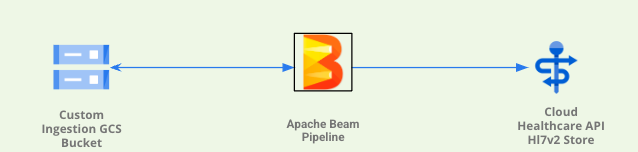

# **Post Hl7v2 messages to Google Cloud Healthcare API HL7v2 store pipeline**

This example demonstrates how to set up an Apache Beam pipeline that reads a HL7 file from [Google Cloud Storage](https://https://cloud.google.com/storage), and calls the [Google Cloud Healthcare API Hl7v2 store to store Hl7 messages](https://cloud.google.com/healthcare-api/docs/how-tos/hl7v2-messages) to extract information from unstructured data. This application can be used in contexts such as reading raw Hl7 messages, if needed parse them or modify them as per your defined Hl7v2 store configurations and store data into Hl7v2 store.

An Apache Beam pipeline is a pipeline that reads input data, transforms that data, and writes output data. It consists of PTransforms and PCollections. A PCollection represents a distributed data set that your Beam pipeline operates on. A PTransform represents a data processing operation, or a step, in your pipeline. It takes one or more PCollections as input, performs a processing function that you provide on the elements of that PCollection, and produces zero or more output PCollection objects.

For details about Apache Beam pipelines, including PTransforms and PCollections, visit the [Beam Programming Guide](https://beam.apache.org/documentation/programming-guide/).

You'll be able to use this notebook to explore the data in each PCollection.

**What is an HL7v2 message?**

HL7 Messages are used to transfer electronic data between disparate healthcare systems, each sending information about a particular event such as a patient admission.

An HL7 message consists of one or more segments. Each segment is displayed on a different line of text. A carriage return character (\r, which is 0D in hexadecimal) separates one segment from another.

Each segment consists of one or more composites, also known as fields. A pipe (|) character is used to separate one composite from another. If a composite contains other composites, these sub-composites (or sub-fields) are normally separated by caret (^) characters.



***Sample HL7v2 Message***

The below reference message shows a sample Hl7v2 messages seperated by \r.

**MSH|^~\&|FROM_APP|FROM_FACILITY|TO_APP|TO_FACILITY|20150503223000||ADT^A01|20150503223000|P|2.5|\r
EVN|A01|20110613083617|\r
PID|1||21004053^^^^MRN||SULLY^BRIAN||19611209|M|||123 MAIN ST^^MOUNTAIN SPRINGS^CO^80439|\r
PV1||I|H73 RM1^1^^HIGHWAY 73 CLINIC||||5148^MARY QUINN|||||||||Y||||||||||||||||||||||||||||20150503223000|**

The file contains many such messages and the objective of this code will be to split and construct messages and POST it to Google Cloud HealthCare API HL7v2 store.

Lets install necessary packages

In [ ]:
!pip install apache-beam[gcp]

**Google Cloud Authentication**

As we are using Google Clous Storage and HealthCare API, we will be requiring tokens to make sure our connection is secure.

Click [this](https://cloud.google.com/free) link to create a new Google Cloud Platform account


**GCP Setup**
1. Authenticate your notebook by `gcloud auth application-default login` in the Colab terminal.

2. Run `gcloud config set project <YOUR-PROJECT>`

Set the variables in the next cell based upon your project and preferences.

Note that below, **us-central1** is hardcoded as the location. This is because of the limited number of [locations](https://cloud.google.com/healthcare-api/docs/how-tos/hl7v2-messages) the API currently supports.

Before running please set the following variables as arguments as mentioned below


In [ ]:
args = {'gcp_project':'xxx', #GCP project ID
        'gcp_region':'xxx', # GCP project region
        'temp_location':'gs://<YOUR Bucket>/tmp', #input location where your HL7 messages are stored in GCS bucket
        'input_file':'gs://<YOUR Bucket>/my_message.hl7', #input location where your HL7 messages are stored in GCS bucket
        'hcapi_project_id':'xxxxxx', #healthcare API project ID
        'hcapi_dataset':'xxxx', #healthcare dataset
        'hcapi_version':'v1', #healthcare API version by defualt v1
        'hcapi_location':'xxxx', #healthcare API configured location
        'hcapi_hl7_store':'xxx', #healthcare api hl7 store
        'hcapi_fhir_store':''}

**Google Cloud Healthcare (HCAPI) API Utils class**

Below is the code snippet which describes the class having healthcare API connections and configurations. Basic functionality includes constructing the hcapi_url as per the input parameters, cleaning the HL7 message in a proper format and posting hl7v2 message to hl7v2 store. You can add more transformations as per your requirements.

In [ ]:
import google.auth
import google.auth.transport.requests
import base64
import json
import hashlib
import requests
import logging
import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions
from apache_beam.options.pipeline_options import SetupOptions
from apache_beam.testing.test_pipeline import TestPipeline
import apache_beam.runners.interactive.interactive_beam as ib
from apache_beam import io

logging.basicConfig(level=logging.INFO, format='%(asctime)s :: %(levelname)s :: %(message)s')

class hcapi_cls:

    def __init__(self, args):
        self.hcapi_hl7_store = str(args['hcapi_hl7_store'])
        self.hcapi_project_id = str(args['hcapi_project_id'])
        self.hcapi_version = str(args['hcapi_version'])
        self.hcapi_location = str(args['hcapi_location'])
        self.hcapi_dataset = str(args['hcapi_dataset'])
        self.hcapi_fhir_store = str(args['hcapi_fhir_store'])
        self.token = None

    def google_api_headers(self):
        """ Function gets the token for the request """
        logging.info("fetching token and refreshing credentials")
        creds, project = google.auth.default()
        auth_req = google.auth.transport.requests.Request()
        creds.refresh(auth_req)
        return {
            "Authorization": f"Bearer {creds.token}",
            "Prefer": "handling=strict"
        }

    def hcapi_dataset_url(self, version=None, project=None, location=None, dataset=None):
        """ This function creates base hcapi dataset url and returns it """
        base = 'https://healthcare.googleapis.com'
        version = self.hcapi_version
        project = self.hcapi_project_id
        location = self.hcapi_location
        dataset = self.hcapi_dataset
        return f'{base}/{version}/projects/{project}/locations/{location}/datasets/{dataset}'

    def hcapi_get(self, url):
        """ Function to send get request to HCAPI """
        response = requests.get(url, headers=self.google_api_headers())
        if not response.ok:
            raise Exception(f'Error with HC API get:\n{response.text}')
        return response.json()

    def hcapi_post(self, url, data):
        """ Function to send post request to HCAPI """
        response = requests.post(url, headers=self.google_api_headers(), json=data)
        if not response.ok:
            raise Exception(f'Error with HC API post:\n{response.text}')
        return response.json()

    def hcapi_delete(self, url):
        """ Function to send delete request to HCAPI """
        response = requests.delete(url, headers=self.google_api_headers())
        if not response.ok:
            raise Exception(f'Error with HC API get:\n{response.text}')
        return response.json()

    def hcapi_hl7_url(self, version=None, project=None, location=None, dataset=None, store=None):
        """ This function creates hcapi hl7V2store url and returns the url """
        base_url = self.hcapi_dataset_url(version=version, project=project,
                                      location=location, dataset=dataset)
        hl7_store = self.hcapi_hl7_store
        return f'{base_url}/hl7V2Stores/{hl7_store}'

    def get_hl7_message(self, message_id):
        """ Function to get message from HL7v2 store using HCAPI URL """
        url = f'{self.hcapi_hl7_url()}/messages/{message_id}'
        return self.hcapi_get(url)

    def post_hl7_message(self, payload):
        """ Function to post messages to HL7v2 store """
        url = f'{self.hcapi_hl7_url()}/messages'
        return self.hcapi_post(url, payload)

    def message_to_hl7_store(self, message):
        """ Function to clean up Hl7 messages with \r seperator before posting to HCAPI """
        messase =str(message)
        message = message.replace('\n', '\r')
        message = message.replace('\\r', '\r')
        message = message.replace('\r\r', '\r')
        encoded = base64.b64encode(str(message).encode())
        payload = {
            "message": {
                "data": encoded.decode()
            }
        }
        return self.post_hl7_message(payload)

    def hcapi_fhir_url(self, version=None, project=None, location=None, dataset=None, store=None):
        """ This function creates hcapi fhir store url and returns it """
        base_url = self.hcapi_dataset_url(version=version, project=project,
                                      location=location, dataset=dataset)
        if store is None:
            raise Exception('No FHIR store specified')
        return f'{base_url}/fhirStores/{store}/fhir'

    def hcapi_fhir_request(self, store_key, query, data={}, method='GET'):
        """ Function to send post request to HCAPI FHIR store """
        store = self.hcapi_fhir_store
        if not store:
            raise Exception(f"Couldn't FHIR find store named {store_key} in config")
        url = self.hcapi_fhir_url(store=store)
        url = f'{url}/{query}' if query else url
        get = lambda q, d: self.hcapi_get(url)
        post = lambda q, d: self.hcapi_post(url, data)
        delete = lambda q, d: self.hcapi_delete(url)
        return {'GET': get, 'POST': post, 'DELETE' : delete}[method](query, data)



**Pipeline Setup**

We will use InteractiveRunner in this notebook.
Following are the DoFn classes which carry out their respective operations

The following class **BuildFileName** takes the file name from the element and converts its into string. You can enhance this class to construct GCS bucket URL, if your GCS bucket prefix remains constant.

In [ ]:
class BuildFileName(beam.DoFn):
    """ Class to get file name from variable and returns the filename """
    def process(self, element):
        logging.info("processing the following file: {}".format(element))
        file_path = str(element)
        yield file_path

The following class **BuildMessages** takes the GCS URL from the above class reads it, separates out each message, appends them into a list and return the list for the next class.

In [ ]:
class BuildMessages(beam.DoFn):
    """ Class to read file, clean and seperate messgaes based on MSH"""
    def process(self, file_name):
        try:
            logging.info("starting to read file: {}".format(file_name))
            file = io.gcsio.GcsIO().open(filename=file_name, mode='r')
            read_file = file.read()
            new_file = str(read_file, encoding='utf-8').replace('\n', '\r')
            logging.info("starting to seperate HL7 messages into list")
            messages=[]
            for line in new_file.split('\r'):
                if line[:3] =='MSH':
                    messages.append(line)
                else:
                    messages[-1]+= line


            logging.info("total number of messages parsed are {}".format(len(messages)))
            return messages
        except Exception as error:
            logging.error("got the following error while processing : {}".format('\n'+str(error)))
            raise Exception




The following class **PostToHL7V2Store** takes the messages return in the earlier class and POST each messages to Hl7v2 store .

In [ ]:
class PostToHL7V2Store(beam.DoFn):
    """ Class to read file, clean and seperate messgaes based on MSH"""
    def process(self, element):
        try:
            logging.info("starting to prepare and post message")
            hl7v2_store_response = hcapi.message_to_hl7_store(element)
            message_id = hl7v2_store_response['name'].split("/")[-1]
            logging.info("successfully posted message to Hl7v2 store with message id :- {}".format(message_id))

            yield message_id
        except Exception as error:
            logging.error("got the following error while processing : {}".format(error))
            raise Exception

The following function sets up a beam pipeline with various other Pipeline options that will extracts messages from Hl7 text and post each hl7 message to hl7v2 store using Google Cloud Healthcare API (HCAPI) api methods.

**"|"** is an overloaded operator that applies a PTransform to a PCollection to produce a new PCollection. Together with |, >> allows you to optionally name a PTransform.

Usage:[PCollection] | [PTransform], **or** [PCollection] | [name] >> [PTransform]

In [ ]:

import apache_beam.runners.interactive.interactive_beam as ib
def run(beam_args,argv=None,save_main_session=True):
    runnertype = "InteractiveRunner"
    project=beam_args['gcp_project']
    region=beam_args['gcp_region']
    temp_location=beam_args['temp_location']

    options = PipelineOptions(
      flags=argv,
      runner=runnertype,
      project=project,
      job_name="my-beam-hl7to-hcapi",
      temp_location=temp_location,
      region=region)
    beam_pipeline_options = PipelineOptions(beam_args)
    beam_pipeline_options.view_as(SetupOptions).save_main_session = save_main_session
    with beam.Pipeline(options=beam_pipeline_options) as pipeline:
        file = (
            pipeline
            | 'reading filename' >> beam.Create([args_dict['input_file']])
            | 'preparing file path' >> beam.ParDo(BuildFileName())
        )
        hl7_messages=(
            file
            | 'parsing hl7 messages' >> beam.ParDo(BuildMessages())
        )
        post_hl7_messages = (
            hl7_messages
            | "posting to hl7v2 Store" >> beam.ParDo(PostToHL7V2Store())
        )


    ib.show_graph(pipeline)


if __name__ == "__main__":
    logging.getLogger().setLevel(logging.INFO)
    args_dict = dict(args)
    hcapi= hcapi_cls(args_dict)
    run(beam_args=args_dict)

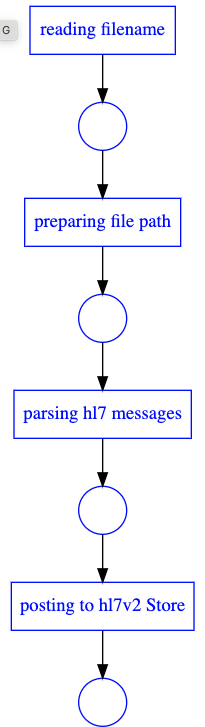